In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xmitgcm 

%matplotlib inline
import os
import imageio
import pandas as pd

import sys
from contextlib import contextmanager


In [3]:
ds_sn = xmitgcm.open_mdsdataset('/home/ceoas/liux8/work/basin_modes/sulu_sea/res100_runs/exp7_cd_q_00025/',prefix=['outs_sn'])
ds_sn

<xarray.Dataset> Size: 2TB
Dimensions:  (XC: 1520, YC: 1908, XG: 1520, YG: 1908, Z: 57, Zp1: 58, Zu: 57,
              Zl: 57, time: 659)
Coordinates: (12/37)
  * XC       (XC) >f4 6kB 112.5 112.5 112.5 112.5 ... 127.7 127.7 127.7 127.7
  * YC       (YC) >f4 8kB -3.295 -3.285 -3.275 -3.265 ... 15.76 15.77 15.77
  * XG       (XG) >f4 6kB 112.5 112.5 112.5 112.5 ... 127.7 127.7 127.7 127.7
  * YG       (YG) >f4 8kB -3.3 -3.29 -3.28 -3.27 ... 15.74 15.75 15.76 15.77
  * Z        (Z) >f4 228B -12.5 -37.5 -62.5 ... -4.062e+03 -4.453e+03 -4.908e+03
  * Zp1      (Zp1) >f4 232B 0.0 -25.0 -50.0 ... -4.247e+03 -4.658e+03 -5.158e+03
    ...       ...
    maskInW  (YC, XG) bool 3MB dask.array<chunksize=(1908, 1520), meta=np.ndarray>
    dxF      (YC, XC) >f4 12MB dask.array<chunksize=(1908, 1520), meta=np.ndarray>
    maskInC  (YC, XC) bool 3MB dask.array<chunksize=(1908, 1520), meta=np.ndarray>
    maskInS  (YG, XC) bool 3MB dask.array<chunksize=(1908, 1520), meta=np.ndarray>
    iter     (time) int64 5kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) timedelta64[ns] 5kB 00:00:00 00:03:00 ... 1 days 08:54:00
Data variables:
    UVEL     (time, Z, YC, XG) float32 436GB dask.array<chunksize=(1, 57, 1908, 1520), meta=np.ndarray>
    VVEL     (time, Z, YG, XC) float32 436GB dask.array<chunksize=(1, 57, 1908, 1520), meta=np.ndarray>
    WVEL     (time, Zl, YC, XC) float32 436GB dask.array<chunksize=(1, 57, 1908, 1520), meta=np.ndarray>
    THETA    (time, Z, YC, XC) float32 436GB dask.array<chunksize=(1, 57, 1908, 1520), meta=np.ndarray>
    PHIHYD   (time, Z, YC, XC) float32 436GB dask.array<chunksize=(1, 57, 1908, 1520), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(data_dir='/home/ceoas/l...

# get KE

In [3]:
drc = ds_sn.drF.values
dx = ds_sn.dxC.values
dy = ds_sn.dyC.values

In [4]:
ke_sum = np.zeros(len(ds_sn.time))
ke_sur_sum = np.zeros(len(ds_sn.time))

ke_sum_inner = np.zeros(len(ds_sn.time))
ke_sur_sum_inner = np.zeros(len(ds_sn.time))

for it in range(len(ds_sn.time)):
    # print it every 100 times
    if it % 10 == 0:
        print(it)

    # mult water layer thickness
    # uvel = ds_sn.UVEL.isel(time=it,XG=slice(150,-150),YC=slice(150,-150)).values
    # vvel = ds_sn.VVEL.isel(time=it,XC=slice(150,-150),YG=slice(150,-150)).values
    
    uvel = ds_sn.UVEL.isel(time=it,).values
    vvel = ds_sn.VVEL.isel(time=it,).values
    # multiply uvel to horizontal grid size dx*dy   
    ke = 0.5*(uvel**2+vvel**2)*drc[:,None,None]*dx[None,:,:]*dy[None,:,:]
    ke_sum[it] = np.sum(ke)
    ke_sur_sum[it] = np.sum(ke[0,:,:])

    ke_sum_inner[it] = np.sum(ke[:,150:-150,150:-150])
    ke_sur_sum_inner[it] = np.sum(ke[0,150:-150,150:-150])


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650


In [11]:
# save the ke_sum_inner, ke_sur_sum_inner, ke_sum_inner, ke_sur_sum_inner to a netcdf file
ds_ke = xr.Dataset({
    'ke_sum_inner': (['time'], ke_sum_inner),
    'ke_sur_sum_inner': (['time'], ke_sur_sum_inner),
    'ke_sum_inner': (['time'], ke_sum_inner),
    'ke_sur_sum_inner': (['time'], ke_sur_sum_inner)
})
ds_ke.to_netcdf('ke_sum_exp7_cd_q_00025.nc')

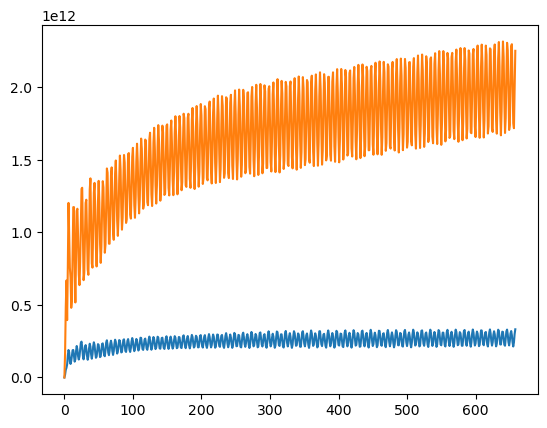

In [5]:
plt.plot(ke_sur_sum_inner)
plt.plot(ke_sum_inner)
# plt.plot(ke_sum)

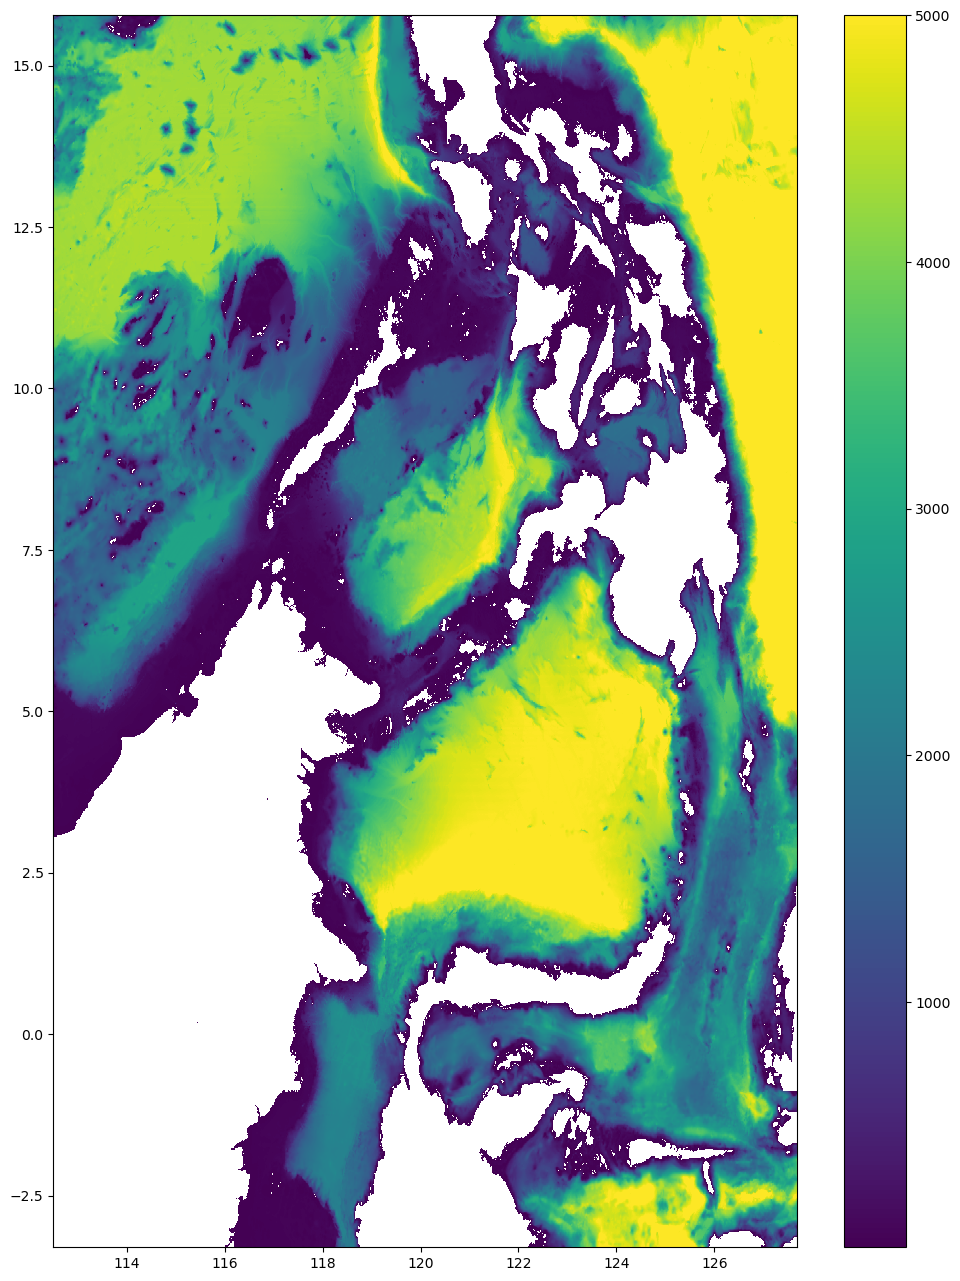

In [47]:
h = ds_sn.Depth.values
h[h==0] = np.nan

plt.figure(figsize=(12,16))
plt.pcolormesh(ds_sn.XC,ds_sn.YC, h)
plt.colorbar()

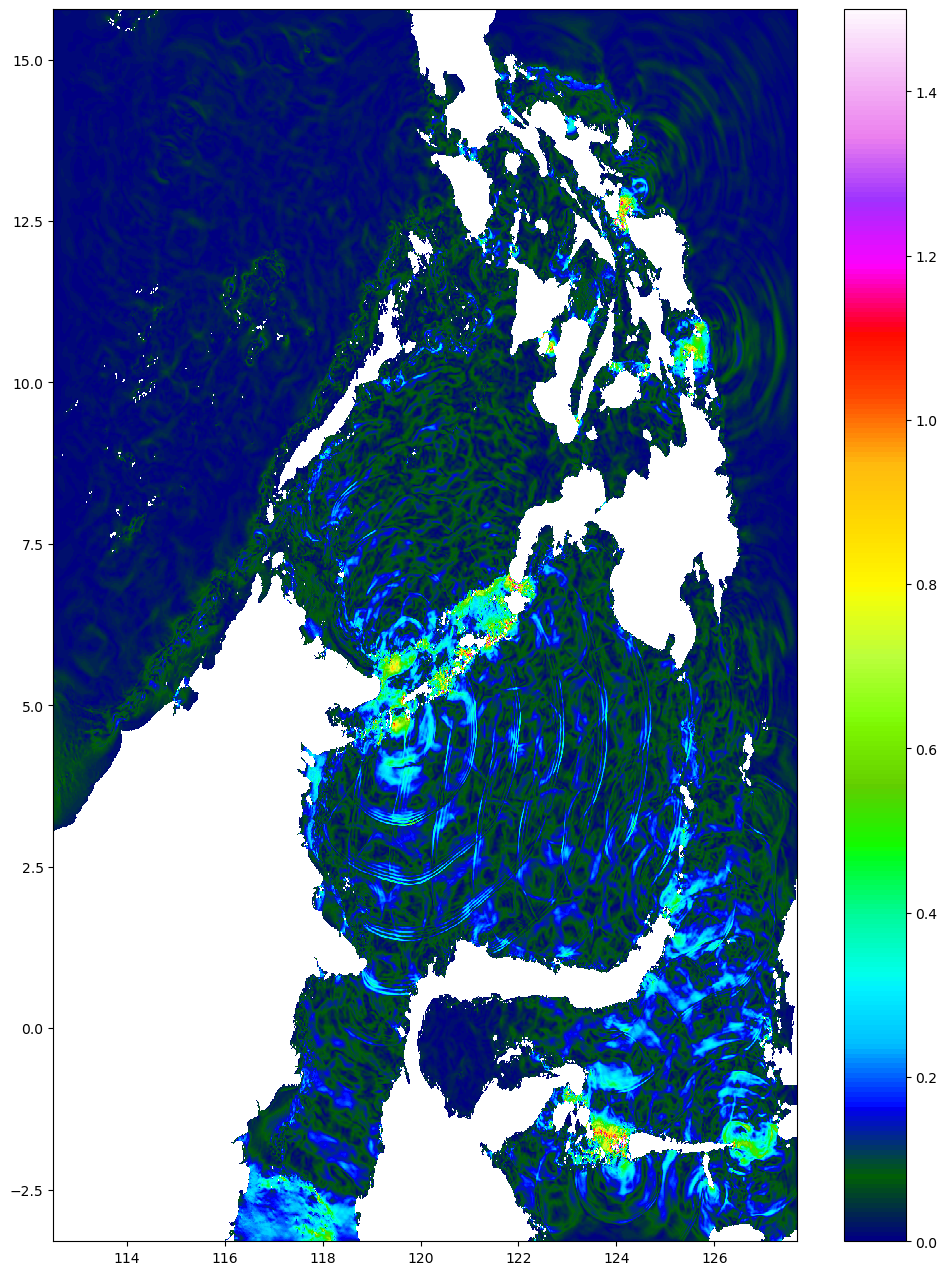

In [17]:
u0 = np.sqrt(vvel[0,:,:]**2+uvel[0,:,:]**2)
u0[u0==0] = np.nan
plt.figure(figsize=(12,16))
plt.pcolormesh(ds_sn.XC,ds_sn.YC, u0,cmap = 'gist_ncar',vmax=1.5)
plt.colorbar()

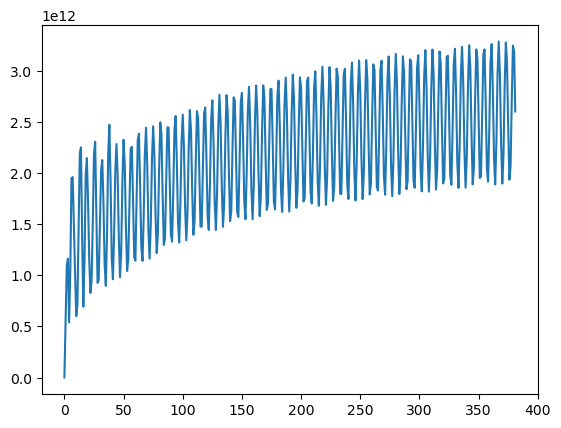

In [7]:
# read STDOUT.0000
stdout_0000 = open('/home/ceoas/liux8/work/basin_modes/sulu_sea/res100_runs/exp7_cd_q_00025/STDOUT.0000','r').read()

# find the line that contains 'ke_mean'
# do loop for all the lines
# save ke_mean to a list
ke_mean_list = []
ke_vol_list = []
for line in stdout_0000.split('\n'):
    if 'ke_mean' in line:
        ke_mean_line = line
        # break
        ke_mean = float(ke_mean_line.split('=')[-1].strip())
        # print(ke_mean)
        ke_mean_list.append(ke_mean)
    elif 'ke_vol' in line:
        ke_vol_line = line
        ke_vol = float(ke_vol_line.split('=')[-1].strip())
        ke_vol_list.append(ke_vol)
# convert ke_mean_list to a numpy array
ke_mean_array = np.array(ke_mean_list)
ke_vol_array = np.array(ke_vol_list)
# plot ke_mean_array
plt.plot(ke_mean_array*ke_vol_array)


Text(0, 0.5, 'KE integrated')

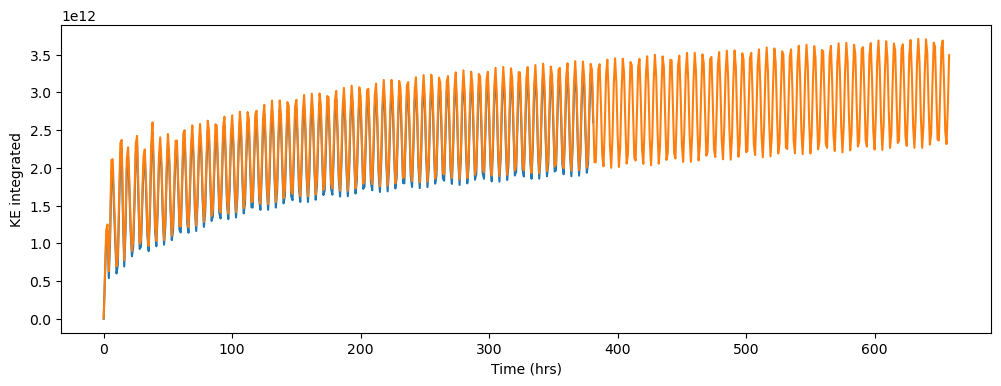

In [19]:
plt.figure(figsize=(12,4))
plt.plot(ke_mean_array*ke_vol_array)
plt.plot(ke_sum)
plt.xlabel('Time (hrs)')
plt.ylabel('KE integrated')

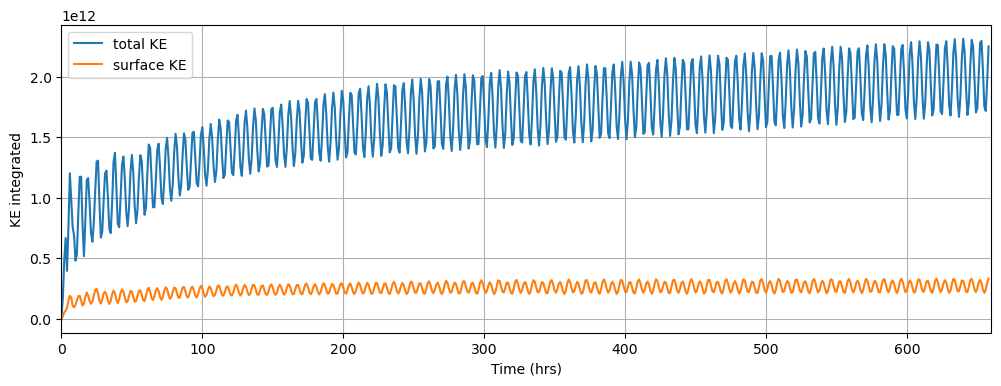

In [18]:
plt.figure(figsize=(12,4))
# plt.plot(ke_mean_array*ke_vol_array)
plt.plot(ke_sum_inner,label='total KE')
plt.plot(ke_sur_sum_inner,label='surface KE')
plt.xlabel('Time (hrs)')
plt.ylabel('KE integrated')
plt.xlim(0,660)
plt.grid()
plt.legend()